In [2]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split

In [3]:
def group_labels(y,ratio,seed=None):
    np.random.seed(seed=seed)
    length = len(y)
    grpwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
    reg_grps = int(length/grpwidth) 
    grp=np.empty(length,dtype=int)
    for i in range(reg_grps):
        b_idx = i * grpwidth
        f_idx = b_idx + grpwidth
        grp[b_idx:f_idx] = np.random.choice(grpwidth,grpwidth,replace=False)
    grp[f_idx:length] = np.random.choice(grpwidth,length-f_idx,replace=False)
    return grp

In [4]:
def split_labels(X,y,grp,binwidth,ratio):
    sel = np.isin(grp,np.arange(int(binwidth*ratio)))
    y_test = y[sel]
    X_test = X[sel]
    sel = np.isin(grp,np.arange(int(binwidth*ratio)),invert=True)
    y_train = y[sel]
    X_train = X[sel]        
    return X_train, X_test, y_train, y_test

In [5]:
def tt_split(X,y,train_ratio,seed=None,val=False):
    X, y = shufflesort(X,y,seed)
    if val:
        valid_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(1-valid_ratio),deno_decimalToFraction(valid_ratio))
        ygrp = group_labels(y,valid_ratio,seed=seed)
        X_train, X_valid, y_train, y_valid = split_labels(X,y,ygrp,binwidth,valid_ratio)

        val_ratio = 0.5
        binwidth = max(deno_decimalToFraction(1-val_ratio),deno_decimalToFraction(val_ratio))
        ygrp = group_labels(y_valid,val_ratio,seed=seed)
        X_val, X_test, y_val, y_test = split_labels(X_valid,y_valid,ygrp,binwidth,val_ratio)

        return X_train, X_val, X_test, y_train, y_val, y_test 
    else:
        test_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(1-test_ratio),deno_decimalToFraction(test_ratio))
        ygrp = group_labels(y,test_ratio,seed=seed)
        X_train, X_test, y_train, y_test = split_labels(X,y,ygrp,binwidth,test_ratio)

        return X_train, X_test, y_train, y_test

In [6]:
from math import floor 
  
# Recursive function to 
# return GCD of a and b 
def gcd(a, b): 
      
    if (a == 0): 
        return b 
    elif (b == 0): 
        return a 
    if (a < b): 
        return gcd(a, b % a) 
    else: 
        return gcd(b, a % b) 

def deno_decimalToFraction(number):
# Returns denominator of fraction converted from decimal   
      
    # Fetch integral value of the decimal 
    intVal = floor(number) 
  
    # Fetch fractional part of the decimal 
    fVal = number - intVal 
  
    # Consider precision value to 
    # convert fractional part to 
    # integral equivalent 
    pVal = 1000000000
  
    # Calculate GCD of integral 
    # equivalent of fractional 
    # part and precision value 
    gcdVal = gcd(round(fVal * pVal), pVal) 
  
    # Calculate num and deno 
    num= round(fVal * pVal) // gcdVal 
    deno = pVal // gcdVal 

#     # Print the fraction 
#     print((intVal * deno) + num, "/", deno) 
  
    return deno 
  

In [7]:
def shufflesort(X,y,seed=None):
# Sorts dataset by label and shuffles labels with the same value
    np.random.seed(seed=seed)
    y_sorted = y.reset_index(drop=True).sort_values()
    idx = y_sorted.index.to_numpy()
    vc = y_sorted.value_counts()
    vals = list(vc[vc > 1].index)
    for val in vals:
        b_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[0])   # First index of value
        f_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[-1])  # Last index of value
        idx[b_idx:f_idx+1] = np.random.permutation(idx[b_idx:f_idx+1])     # Permute order of indices for value
    y_sorted = y_sorted.reindex(idx)
    y = y.iloc[y_sorted.index]
    X = X.iloc[y_sorted.index]
    return X,y

In [8]:
def ou_accuracy(actu,pred,masked=False):
    with open('data/df_2000_2019.pkl','rb') as f:
        dfall = pickle.load(f)
    ou = dfall.loc[actu.index,'Over_Under']
        
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        if not(masked):
            corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot = (actu<ou).sum() + (actu>ou).sum()
            return corr/tot
        else:
            mask = abs(pred-ou) >= 4
            actu = actu[mask]
            pred = pred[mask]
            ou = ou[mask]
            corr1 = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot1 = (actu<ou).sum() + (actu>ou).sum()
            return corr1/tot1

In [9]:
def regress(reg,Xtrain,Xtest,ytrain,ytest,cv=5,print_metrics=True,print_coef=True,return_metrics=False):
    robust = RobustScaler()
    sca_train = robust.fit_transform(Xtrain)
    sca_test = robust.transform(Xtest)
    val = cross_validate(reg, sca_train, ytrain, cv=cv, return_estimator=True,
                                scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
                                        'acc':make_scorer(ou_accuracy,greater_is_better=True)})
    acc = (np.mean(val['test_acc']),np.std(val['test_acc']))
    mae = (np.mean(-val['test_mae']),np.std(-val['test_mae']))
    best_estimator = val['estimator'][val['test_mae'].argmax()]

    ypred=best_estimator.predict(sca_test)
    mae_test=mean_absolute_error(ytest,ypred)
    acc_test = ou_accuracy(ytest,ypred)
    sorted_coef = get_coef(best_estimator.coef_,Xtrain.columns)
    if print_metrics:
        print(f'MAE_train = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
        print(-val['test_mae'])
#        print(f'MAE_test = {mae_test:.3f}, Accuracy_test = {acc_test:.3f}')
    if print_coef:
        print(sorted_coef)
    if return_metrics:
        return mae_test,acc_test
    else:
        return

In [10]:
def get_coef(coef_,cols):
    coef = pd.DataFrame(coef_, cols, columns=['LR Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

In [11]:
def cv_model(X,y,gfold,grp,model,scale=True):
    from sklearn.preprocessing import RobustScaler
    mae=[]
    acc=[]
    robust = RobustScaler()
#    for fold, (train_index, valid_index) in enumerate(gfold.split(X, y, grp)):
    for train_index, valid_index in gfold.split(X, y, grp):
        X_train,X_valid = X.iloc[train_index],X.iloc[valid_index]
        y_train,y_valid = y.iloc[train_index],y.iloc[valid_index]
        if scale:
            sca_train = robust.fit_transform(X_train)
            sca_valid = robust.transform(X_valid)
            model.fit(sca_train,y_train)
            y_pred = model.predict(sca_valid)
        else:
            model.fit(X_train,y_train)
            y_pred = model.predict(X_valid)            
        mae.append(mean_absolute_error(y_valid,y_pred))
        acc.append(ou_accuracy(y_valid,y_pred))
    print(model,f'n_splits = {gfold.get_n_splits()}')
    return mae, acc

In [12]:
def print_time():
    ct = datetime.datetime.now()
    print(ct.strftime('%m-%d-%y %H:%M:%S'))
    return

In [364]:
def plot_coef(OLS,fig,ax,p_thresh=None):
    if p_thresh is not None:
        mask = OLS.pvalues[1:] < p_thresh
        params = OLS.params[1:][mask]
        conf_int = OLS.conf_int()[1:][mask]
    else:
        params = OLS.params[1:]
        conf_int = OLS.conf_int()[1:]
        
    err_series = params - conf_int[0]
    coef_df = pd.DataFrame({'coef': params.values,
                            'err': err_series.values,
                            'varname': err_series.index.values
                           }).sort_values(by='coef',ascending=False)
    coef_df.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    return

In [14]:
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']
LR = linear_model.LinearRegression()
robust = RobustScaler()

In [368]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

path = 'data/df_2010_2019_5wk.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

In [191]:
with open('data/df_2000_2019_5wk.pkl','rb') as f:
    dfcomp = pickle.load(f)

In [16]:
print_time()
train_ratio = 0.70
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
# W/out Pass/Rush Metrics, Scores, Possession, Plays, dome, TOs, TDs
X_train, X_val, X_test, y_train, y_val, y_test  = tt_split(X, y, train_ratio, seed=seed, val=True)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
vif.round(2).sort_values(by='VIF Factor',ascending=False)

02-14-21 05:31:44


,Features,VIF Factor
1,H_Pts_Opp,4.33
3,V_Pts_Opp,4.27
2,V_Pts,4.11
0,H_Pts,3.79
5,V_Off_Pass,2.99
4,H_Off_Pass,2.96
35,dome,2.44
7,V_Off_Rush,2.12
9,V_Def_Pass,2.11
6,H_Off_Rush,2.05


In [72]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
not_scaled = sm.OLS(y_train, X_train).fit()
ypred=not_scaled.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
#plot_coef(n_scaled,p_thresh=0.10)
not_scaled.summary()

MAE = 11.115043909468985
Validation Accuracy = 0.5019607843137255


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.407
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           9.89e-17
Time:                        09:18:12   Log-Likelihood:                -4851.5
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1176   BIC:                             9980.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            348.3914    355.429      0.980      0.327    -348.954    1045.736
H_Pts              0.3109      0.140      2.228      0.026       0.037       0.585
H_Pts_Opp          0.1687      0.156      1.082      0.279      -0.137       0.474
V_Pts              0.0203      0.136      0.149      0.882      -0.248       0.288
V_Pts_Opp         -0.2242      0.153     -1.467      0.143      -0.524       0.076
H_Off_Pass         0.0181      0.015      1.197      0.231      -0.012       0.048
V_Off_Pass         0.0483      0.015      3.184      0.001       0.019       0.078
H_Off_Rush         0.0016      0.020      0.080      0.936      -0.037       0.040
V_Off_Rush         0.0351      0.020      1.734      0.083      -0.005       0.075
H_Def_Pass         0.0017      0.015      0.112      0.911      -0.028       0.031
V_Def_Pass         0.0421      0.015      2.802      0.005       0.013       0.072
H_Def_Rush         0.0392      0.020      1.928      0.054      -0.001       0.079
V_Def_Rush         0.0417      0.020      2.092      0.037       0.003       0.081
H_TD_on_Def       -4.9847      2.485     -2.006      0.045      -9.859      -0.110
V_TD_on_Def       -3.3616      2.506     -1.341      0.180      -8.278       1.555
H_FG_Pct          -3.8323      3.263     -1.175      0.240     -10.233       2.569
V_FG_Pct           3.1010      3.089      1.004      0.316      -2.960       9.162
H_RZ_Def_Pct      -3.7772      4.108     -0.919      0.358     -11.837       4.283
V_RZ_Def_Pct      16.2625      4.081      3.985      0.000       8.255      24.270
H_TO_Gain          0.8590      0.831      1.033      0.302      -0.772       2.490
V_TO_Gain          1.0641      0.829      1.283      0.200      -0.563       2.692
H_TO_Lost         -1.0125      0.859     -1.179      0.239      -2.698       0.673
V_TO_Lost          1.2698      0.829      1.531      0.126      -0.357       2.897
H_Yds_Pen          0.0130      0.031      0.413      0.680      -0.049       0.075
V_Yds_Pen          0.0210      0.032      0.666      0.505      -0.041       0.083
H_Sacks_Def        0.5003      0.628      0.796      0.426      -0.733       1.733
V_Sacks_Def        0.4326      0.633      0.683      0.495      -0.810       1.675
H_Tackles_Loss     0.4338      0.440      0.985      0.325      -0.430       1.298
V_Tackles_Loss     0.3032      0.427      0.711      0.477      -0.534       1.140
H_Kickret         -0.0656      0.076     -0.864      0.388      -0.215       0.083
V_Kickret         -0.0028      0.071     -0.039      0.969      -0.142       0.136
H_Puntret          0.0943      0.101      0.930      0.352      -0.105       0.293
V_Puntret         -0.2426      0.102     -2.378      0.018      -0.443      -0.042
Temperature       -0.0065      0.027     -0.241      0.810      -0.060       0.047
Wind        

In [367]:
dfgame

,Home_Team,Vis_Team,H_Game,V_Game,Over_Under,Tot_Pts,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,fieldturf,grass,matrixturf,sportturf,dome,Week,Year,H_Win,Margin,Over
Code,,,,,,,,,,,,,,,,,,,,,
201812020jax,Jacksonville Jaguars,Indianapolis Colts,6,0,45.5,6,17.6,23.4,34.6,18.6,...,0,1,0,0,0,13,2018,1,6,0
201712310phi,Philadelphia Eagles,Dallas Cowboys,0,6,41.0,6,27.4,20.2,21.2,18.0,...,0,1,0,0,0,17,2017,0,-6,0
201910200was,Washington Redskins,San Francisco 49ers,0,9,39.0,9,12.6,27.0,29.4,12.8,...,0,1,0,0,0,7,2019,0,-9,0
201010310nyj,New York Jets,Green Bay Packers,0,9,42.0,9,30.0,18.2,21.2,21.8,...,1,0,0,0,0,8,2010,0,-9,0
201110230cle,Cleveland Browns,Seattle Seahawks,6,3,41.0,9,18.2,23.4,18.8,24.4,...,0,1,0,0,0,7,2011,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201312150rai,Oakland Raiders,Kansas City Chiefs,31,56,44.0,87,23.6,27.6,30.2,25.2,...,0,1,0,0,0,15,2013,0,-25,1
201612180crd,Arizona Cardinals,New Orleans Saints,41,48,48.5,89,24.0,27.4,23.2,22.6,...,0,1,0,0,1,15,2016,0,-7,1
201912080nor,New Orleans Saints,San Francisco 49ers,46,48,45.0,94,26.8,20.2,28.4,21.2,...,0,0,0,0,1,14,2019,0,-2,1


MAE = 11.115043909468998
Validation Accuracy = 0.5019607843137255


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.407
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           9.89e-17
Time:                        12:36:37   Log-Likelihood:                -4851.5
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1176   BIC:                             9980.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             43.5351      0.638     68.205      0.000      42.283      44.787
H_Pts              2.1140      0.949      2.228      0.026       0.252       3.976
H_Pts_Opp          1.1469      1.060      1.082      0.279      -0.932       3.226
V_Pts              0.1541      1.037      0.149      0.882      -1.881       2.189
V_Pts_Opp         -1.6594      1.131     -1.467      0.143      -3.878       0.559
H_Off_Pass         1.0601      0.885      1.197      0.231      -0.677       2.797
V_Off_Pass         2.9236      0.918      3.184      0.001       1.122       4.725
H_Off_Rush         0.0569      0.712      0.080      0.936      -1.339       1.453
V_Off_Rush         1.2765      0.736      1.734      0.083      -0.168       2.721
H_Def_Pass         0.0857      0.763      0.112      0.911      -1.411       1.582
V_Def_Pass         2.1727      0.776      2.802      0.005       0.651       3.694
H_Def_Rush         1.2806      0.664      1.928      0.054      -0.023       2.584
V_Def_Rush         1.4768      0.706      2.092      0.037       0.092       2.862
H_TD_on_Def       -0.9969      0.497     -2.006      0.045      -1.972      -0.022
V_TD_on_Def       -0.6723      0.501     -1.341      0.180      -1.656       0.311
H_FG_Pct          -0.6387      0.544     -1.175      0.240      -1.706       0.428
V_FG_Pct           0.5367      0.535      1.004      0.316      -0.512       1.586
H_RZ_Def_Pct      -0.6480      0.705     -0.919      0.358      -2.031       0.735
V_RZ_Def_Pct       2.5678      0.644      3.985      0.000       1.303       3.832
H_TO_Gain          0.6872      0.665      1.033      0.302      -0.617       1.992
V_TO_Gain          0.8513      0.664      1.283      0.200      -0.451       2.153
H_TO_Lost         -0.8100      0.687     -1.179      0.239      -2.158       0.538
V_TO_Lost          1.0159      0.663      1.531      0.126      -0.286       2.318
H_Yds_Pen          0.2453      0.595      0.413      0.680      -0.921       1.412
V_Yds_Pen          0.3653      0.548      0.666      0.505      -0.710       1.441
H_Sacks_Def        0.6003      0.754      0.796      0.426      -0.879       2.080
V_Sacks_Def        0.5191      0.760      0.683      0.495      -0.972       2.010
H_Tackles_Loss     0.6508      0.660      0.985      0.325      -0.645       1.947
V_Tackles_Loss     0.5458      0.768      0.711      0.477      -0.960       2.052
H_Kickret         -0.4397      0.509     -0.864      0.388      -1.439       0.559
V_Kickret         -0.0187      0.475     -0.039      0.969      -0.952       0.914
H_Puntret          0.4299      0.462      0.930      0.352      -0.477       1.337
V_Puntret         -1.1563      0.486     -2.378      0.018      -2.110      -0.202
Temperature       -0.1762      0.732     -0.241      0.810      -1.611       1.259
Wind        

<Figure size 432x360 with 0 Axes>

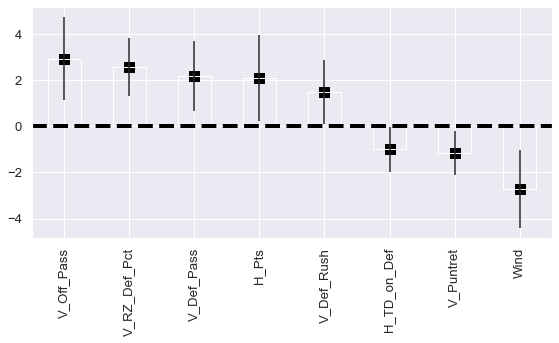

In [370]:
# Scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
fig16 = plt.figure(figsize=(6,5))
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
sca_train = sm.add_constant(sca_train)
sca_val = robust.transform(X_val)
sca_val = sm.add_constant(sca_val)
scaled = sm.OLS(y_train, sca_train).fit()
ypred=scaled.predict(sca_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
fig16, ax = plt.subplots(figsize=(8, 5))
plot_coef(scaled,fig16,ax,p_thresh=0.05)
fig16.tight_layout()
fig16.savefig('plots/fig16.png')
scaled.summary()

In [371]:
thresh = 0.10
df1=not_scaled.summary2().tables[1]
df2=scaled.summary2().tables[1]
df=pd.concat([df1.iloc[:,0],df2.iloc[:,0],df1.iloc[:,3],df1.iloc[:,4],df1.iloc[:,5]],axis=1)
df.columns=['Unscaled','Scaled','p-coef','min','max']
threshed=df[df['p-coef']<thresh]

In [372]:
threshed.sort_values(by=['Scaled'],key=lambda x: abs(threshed['Scaled']),ascending=False)

,Unscaled,Scaled,p-coef,min,max
V_Off_Pass,0.048324,2.923587,0.001490,0.018548,0.078100
Wind,-0.271791,-2.717907,0.001494,-0.439308,-0.104274
V_RZ_Def_Pct,16.262454,2.567756,0.000072,8.254773,24.270135
V_Def_Pass,0.042107,2.172711,0.005169,0.012618,0.071595
H_Pts,0.310877,2.113964,0.026085,0.037089,0.584665
V_Def_Rush,0.041718,1.476830,0.036650,0.002593,0.080844
H_Def_Rush,0.039162,1.280588,0.054130,-0.000696,0.079019
V_Off_Rush,0.035069,1.276494,0.083264,-0.004622,0.074759
V_Puntret,-0.242582,-1.156307,0.017557,-0.442709,-0.042455
H_TD_on_Def,-4.984654,-0.996931,0.045059,-9.859347,-0.109961


In [164]:
dfgame[dfgame['V_Game']>dfgame['H_Game']]['Tot_Pts'].mean()

44.74300932090546

In [165]:
dfgame[dfgame['V_Game']<dfgame['H_Game']]['Tot_Pts'].mean()

45.47959183673469

In [180]:
dfgame['V_Off_Pass'].corr(dfgame['Tot_Pts'])

0.16739107162855826

In [181]:
dfgame['H_Off_Pass'].corr(dfgame['Tot_Pts'])

0.13072478364675974

In [184]:
dfgame['V_Off_Pass'].corr(dfgame['V_Game'].astype('int'))

0.19870764352332926

In [185]:
dfgame['H_Off_Pass'].corr(dfgame['H_Game'].astype('int'))

0.1706253356325197

In [198]:
dfgame['H_Def_Rush'].corr(dfgame['V_Game'].astype('int'))

0.09800926897237958

In [67]:
hcoef=0.057
hconst=13.460
print(hcoef*400+hconst)

36.260000000000005


In [199]:
dfgame['V_Def_Rush'].corr(dfgame['H_Game'].astype('int'))

0.1038621031484295

In [192]:
dfgame['Wind'].corr(dfgame['H_Game'].astype('int'))

-0.08233918068220109

In [193]:
dfgame['Wind'].corr(dfgame['V_Game'].astype('int'))

-0.06285708318520514

In [194]:
dfgame['Temperature'].corr(dfgame['H_Game'].astype('int'))

-0.008867109994968215

In [195]:
dfgame['Temperature'].corr(dfgame['V_Game'].astype('int'))

0.05716498816339912

In [17]:
dfgame[['H_Game','V_Game']] = dfgame[['H_Game','V_Game']].astype('int')

In [26]:
hg75 = dfgame['H_Game'].quantile(0.75)
hg25 = dfgame['H_Game'].quantile(0.25)
vg75 = dfgame['V_Game'].quantile(0.75)
vg25 = dfgame['V_Game'].quantile(0.25)
print(f'H_Game IQR is {hg75} - {hg25} = {hg75 - hg25}')
print(f'V_Game IQR is {vg75} - {vg25} = {vg75 - vg25}')

H_Game IQR is 30.0 - 17.0 = 13.0
V_Game IQR is 27.0 - 14.0 = 13.0


In [41]:
hmin, hmax = min(dfgame['H_Pts']), max(dfgame['H_Pts'])
vmin, vmax = min(dfgame['V_Pts']), max(dfgame['V_Pts'])
hrange, vrange = hmax - hmin, vmax - vmin
print(f'Range of H_Pts is {hrange}, {hmin}, {hmax}')
print(f'Range of V_Pts is {vrange}, {vmin}, {vmax}')

Range of H_Pts is 38.6, 7.4, 46.0
Range of V_Pts is 36.8, 7.0, 43.8


In [32]:
hp75 = dfgame['H_Pts'].quantile(0.75)
hp25 = dfgame['H_Pts'].quantile(0.25)
vp75 = dfgame['V_Pts'].quantile(0.75)
vp25 = dfgame['V_Pts'].quantile(0.25)
print(f'H_Pts IQR is {hp75} - {hp25} = {hp75 - hp25}')
print(f'V_Pts IQR is {vp75} - {vp25} = {vp75 - vp25}')

H_Pts IQR is 26.1 - 18.8 = 7.300000000000001
V_Pts IQR is 26.4 - 19.0 = 7.399999999999999


In [33]:
mean = dfgame['Tot_Pts'].mean()
sub = dfgame[dfgame['Tot_Pts'] > mean]
hp75 = sub['H_Pts'].quantile(0.75)
hp25 = sub['H_Pts'].quantile(0.25)
vp75 = sub['V_Pts'].quantile(0.75)
vp25 = sub['V_Pts'].quantile(0.25)
print(f'H_Pts IQR for high score is {hp75} - {hp25} = {hp75 - hp25}')
print(f'V_Pts IQR is high score is {vp75} - {vp25} = {vp75 - vp25}')

H_Pts IQR for high score is 26.8 - 19.6 = 7.199999999999999
V_Pts IQR is high score is 27.2 - 20.0 = 7.199999999999999


/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


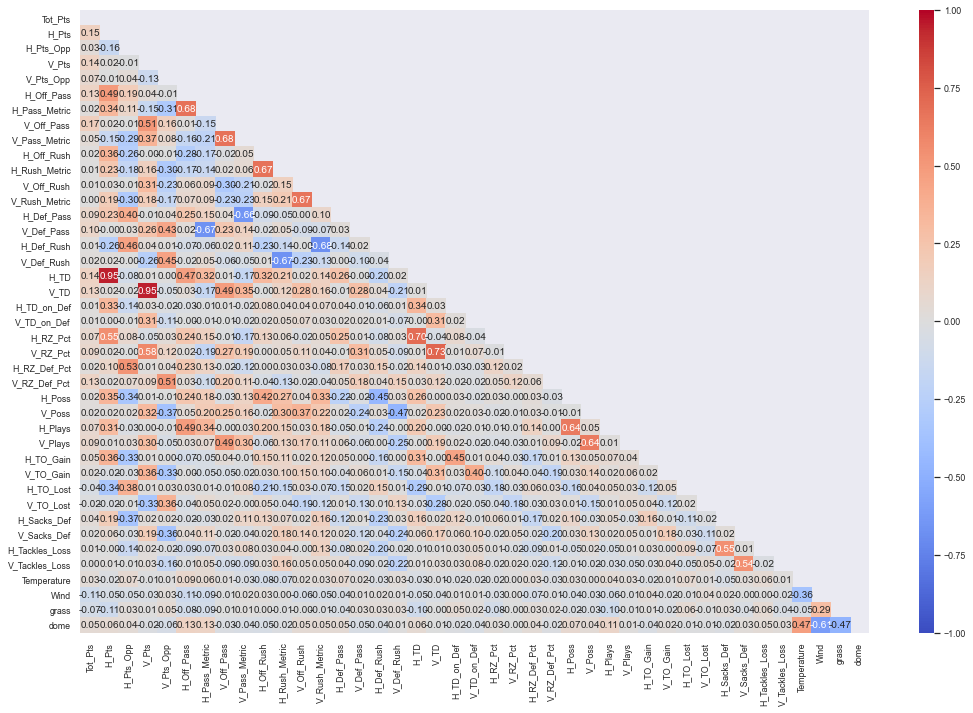

In [37]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

dropped = ['Home_Team','Vis_Team','H_Game','V_Game','Over_Under',
           'a_turf','astroplay','fieldturf','sportturf','matrixturf']
                 
cols=dfgame.columns.drop(dropped)

Stats=dfgame[cols]
coeffs = Stats.corr()
moretodrop = []
for col in cols:
    if (col != 'Tot_Pts'):
        max_coef = coeffs.loc[col,np.abs(coeffs.loc[col]).rank(ascending=False) == 2].values[0] # neglect self-correlation
        if np.abs(max_coef) < 0.35: moretodrop.append(col)
coeffs = coeffs.drop(moretodrop).drop(moretodrop,axis=1)
mask = np.triu(coeffs)
sns.set(font_scale=0.8)
#sns.set(font_scale=1.0)
sns.heatmap(coeffs,vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',cbar_kws={'aspect':40},fmt='.2f',annot_kws={"size": 10})
fig.tight_layout()
fig.show()

MAE = 11.096696677786646
Validation Accuracy = 0.5058823529411764


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.464
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           1.08e-16
Time:                        03:56:44   Log-Likelihood:                -4852.6
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1177   BIC:                             9975.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             43.5515      0.639     68.208      0.000      42.299      44.804
H_Pts              2.1179      0.949      2.231      0.026       0.255       3.981
H_Pts_Opp          1.2446      1.058      1.176      0.240      -0.831       3.321
V_Pts              0.0199      1.034      0.019      0.985      -2.008       2.048
H_Off_Pass         1.0543      0.886      1.190      0.234      -0.684       2.792
V_Off_Pass         3.0478      0.915      3.332      0.001       1.253       4.842
H_Off_Rush         0.0619      0.712      0.087      0.931      -1.335       1.459
V_Off_Rush         1.3696      0.734      1.866      0.062      -0.070       2.810
H_Def_Pass         0.0096      0.761      0.013      0.990      -1.484       1.503
V_Def_Pass         1.4405      0.594      2.425      0.015       0.275       2.606
H_Def_Rush         1.2278      0.664      1.850      0.065      -0.074       2.530
V_Def_Rush         0.8978      0.586      1.533      0.126      -0.251       2.047
H_TD_on_Def       -1.0023      0.497     -2.016      0.044      -1.978      -0.027
V_TD_on_Def       -0.6758      0.501     -1.348      0.178      -1.660       0.308
H_FG_Pct          -0.6460      0.544     -1.187      0.235      -1.713       0.421
V_FG_Pct           0.5577      0.535      1.043      0.297      -0.491       1.607
H_RZ_Def_Pct      -0.6972      0.704     -0.990      0.322      -2.079       0.685
V_RZ_Def_Pct       2.1106      0.564      3.739      0.000       1.003       3.218
H_TO_Gain          0.7000      0.665      1.052      0.293      -0.605       2.005
V_TO_Gain          1.1956      0.621      1.925      0.054      -0.023       2.414
H_TO_Lost         -0.8607      0.687     -1.253      0.210      -2.208       0.487
V_TO_Lost          0.4918      0.559      0.879      0.380      -0.606       1.589
H_Yds_Pen          0.2230      0.595      0.375      0.708      -0.944       1.390
V_Yds_Pen          0.2148      0.539      0.399      0.690      -0.842       1.272
H_Sacks_Def        0.5653      0.754      0.750      0.454      -0.914       2.045
V_Sacks_Def        0.7342      0.746      0.984      0.325      -0.729       2.198
H_Tackles_Loss     0.6881      0.660      1.042      0.298      -0.607       1.984
V_Tackles_Loss     0.4313      0.764      0.565      0.573      -1.068       1.931
H_Kickret         -0.4122      0.509     -0.810      0.418      -1.411       0.586
V_Kickret          0.0546      0.473      0.115      0.908      -0.874       0.983
H_Puntret          0.4451      0.462      0.963      0.336      -0.462       1.352
V_Puntret         -1.0950      0.485     -2.259      0.024      -2.046      -0.144
Temperature       -0.1911      0.732     -0.261      0.794      -1.627       1.245
Wind              -2.7464      0.854     -3.216      0.001      -4.422      -1.071
grass       

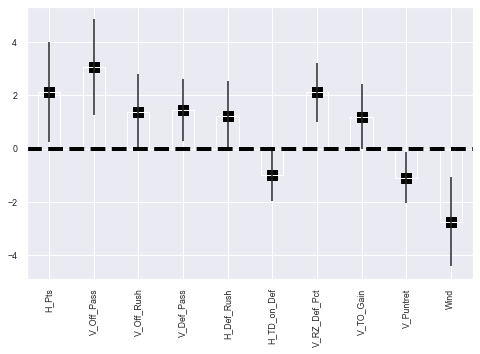

In [38]:
# Scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

drop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','V_Pts_Opp']
X = X.drop(drop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
sca_train = sm.add_constant(sca_train)
sca_val = robust.transform(X_val)
sca_val = sm.add_constant(sca_val)
scaled = sm.OLS(y_train, sca_train).fit()
ypred=scaled.predict(sca_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
plot_coef(scaled,p_thresh=0.10)
scaled.summary()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


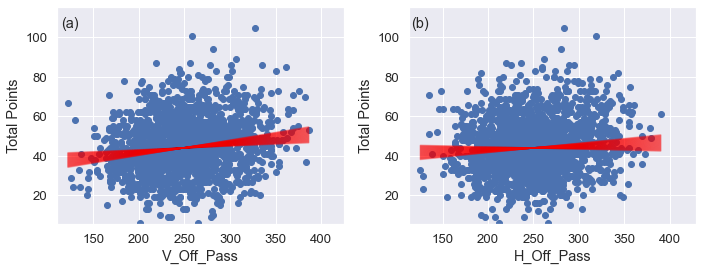

In [380]:
fig17 = plt.figure(figsize=(10,4))
cats = ['V_Off_Pass','H_Off_Pass']
lbl = ['(a)','(b)']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    _ = fig17.add_subplot(1,2,i+1)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    plt.text(115,105,lbl[i],fontsize='medium')
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for j in range(len(mm)):
        plt.plot(xx,mm[j]*xx+b[j],c='red',alpha=0.1)
fig17.tight_layout()
fig17.show()
fig17.savefig('plots/fig17.png')

In [575]:
print(dfgame['Tot_Pts'].mean())
print(dfgame['H_Game'].mean())
print(dfgame['V_Game'].mean())

45.15158501440922
23.643804034582132
21.50778097982709


In [578]:
wind=dfgame[dfgame['Wind']>20]

In [579]:
print(wind['Tot_Pts'].mean())
print(wind['H_Game'].mean())
print(wind['V_Game'].mean())

42.46666666666667
21.166666666666668
21.3


In [582]:
dfgame['Wind'].sort_values(ascending=False).iloc[0:10]

Code
201612040pit    71
201111130cle    40
201311240cle    31
201511150rai    31
201112040cle    30
201012120chi    30
201611200cle    27
201311240rav    26
201512240rai    25
201011210sfo    25
Name: Wind, dtype: int64

In [594]:
num = 25
hg = np.zeros(num)
vg = np.zeros(num)
tot = np.zeros(num)
for w in range(num):
    mask = (dfgame['Wind'] >= w)
    hg[w] = dfgame[mask]['H_Game'].mean()
    vg[w] = dfgame[mask]['V_Game'].mean()
    tot[w] = dfgame[mask]['Tot_Pts'].mean()
wnd = pd.DataFrame({'Mean Home':hg,'Mean Vis':vg,'Mean Total':tot},index=range(num))

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


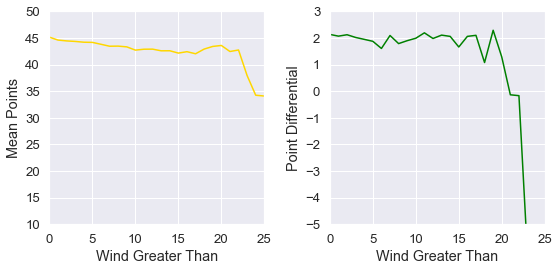

In [601]:
fig = plt.figure(figsize=(8,4))
_ = fig.add_subplot(1,2,1)
x = wnd.index
y = wnd['Mean Total']
plt.plot(x,y,c='goldenrod',label='Total')
plt.xlabel('Wind Greater Than')
plt.ylabel('Mean Points')
plt.xlim(0,25)
plt.ylim(30,50)
_ = fig.add_subplot(1,2,2)
y = wnd['Mean Home'] - wnd['Mean Vis']
plt.plot(x,y,c='green',label='Home')
plt.xlabel('Wind Greater Than')
plt.ylabel('Point Differential')
plt.xlim(0,25)
plt.ylim(-5,3)
fig.tight_layout()
fig.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
col1 = 'H_Off_Rush'
col2 = 'V_Off_Rush'
_ = fig.add_subplot(1,1,1)
y = sub1['Tot_Pts']
x = sub1[col1]
plt.scatter(x,y,c='red')
y = nsub1['Tot_Pts']
x = nsub1[col1]
plt.scatter(x,y,c='lightskyblue',alpha=0.3)
plt.xlabel(col1)
plt.ylabel('Total Points')
plt.xlim(min(x)*0.9,max(x)*1.1)
plt.ylim(45,max(y)*1.1)
_ = fig.add_subplot(1,2,2)
y = sub2['Tot_Pts']
x = sub2[col2]
plt.scatter(x,y,c='red')
y = nsub2['Tot_Pts']
x = nsub2[col2]
plt.scatter(x,y,c='lightskyblue',alpha=0.3)
plt.xlabel(col2)
plt.ylabel('Total Points')
plt.xlim(min(x)*0.9,max(x)*1.1)
plt.ylim(45,max(y)*1.1)
fig.tight_layout()
fig.show()

print(sub1[col1].mean())
print(sub2[col2].mean())
print(dfgame[col1].mean(),dfgame[col2].mean())

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


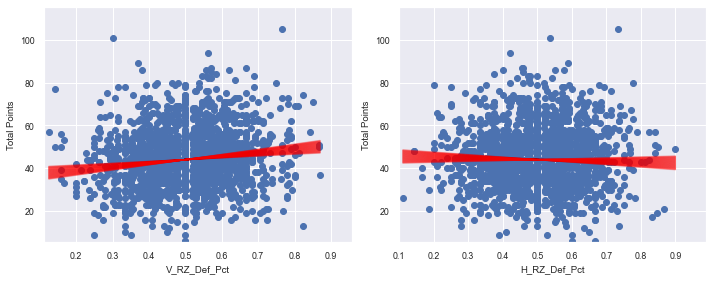

In [147]:
fig = plt.figure(figsize=(10,4))
cats = ['V_RZ_Def_Pct','H_RZ_Def_Pct']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(1,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
fig.tight_layout()
fig.show()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


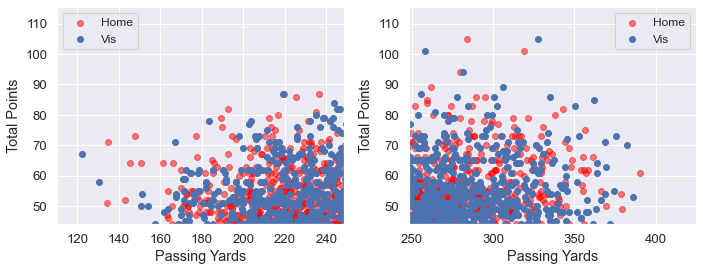

In [481]:
fig18 = plt.figure(figsize=(10,4))
cat = 'V_Off_Pass'
ovrlay = 'H_Off_Pass'
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
x = dfgame[cat]
xover = dfgame[ovrlay]
# #    m = df.loc[cat,'Unscaled']
#     min_m = df.loc[cat,'min']
#     max_m = df.loc[cat,'max']
#     mm = np.linspace(min_m,max_m,100)
#     x0 = np.median(dfgame[cat])
_ = fig18.add_subplot(1,2,1)
plt.scatter(xover,y,c='red',alpha=0.5,label='Home')
plt.scatter(x,y,label='Vis')
plt.xlabel('Passing Yards')
plt.ylabel('Total Points')
plt.xlim(min(x)*0.9,np.median(x))
plt.ylim(np.median(y),max(y)*1.1)
plt.legend(loc='upper left',fontsize='small')
_ = fig18.add_subplot(1,2,2)
plt.scatter(xover,y,c='red',alpha=0.5,label='Home')
plt.scatter(x,y,label='Vis')
plt.xlabel('Passing Yards')
plt.ylabel('Total Points')
plt.xlim(np.median(x),max(x)*1.1)
plt.ylim(np.median(y),max(y)*1.1)
plt.legend(loc='upper right',fontsize='small')
fig18.tight_layout()
fig18.show()
fig18.savefig('plots/fig18.png')

In [483]:
print(dfgame['H_Off_Pass'].corr(dfgame['H_Game']))
print(dfgame['V_Off_Pass'].corr(dfgame['V_Game']))
print()
print(dfgame['H_Off_Pass'].corr(dfgame['Tot_Pts']))
print(dfgame['V_Off_Pass'].corr(dfgame['Tot_Pts']))

0.1706253356325197
0.19870764352332926

0.13072478364675974
0.16739107162855826


In [495]:
maskpts = dfgame['Tot_Pts'] > dfgame['Tot_Pts'].median()
maskhps = dfgame['H_Off_Pass'] < 200
maskvps = dfgame['V_Off_Pass'] < 200
print(len(dfgame[maskhps & maskpts]))
print(len(dfgame[maskvps & maskpts]))
print(sbh['H_Off_Rush'].mean(),sbh['V_Off_Rush'].mean())
print(sbv['V_Off_Rush'].mean(),sbv['H_Off_Rush'].mean())

95
76


In [496]:
maskpts = dfgame['Tot_Pts'] > dfgame['Tot_Pts'].median()
maskhps = dfgame['H_Off_Pass'] > 300
maskvps = dfgame['V_Off_Pass'] > 300
print(len(dfgame[maskhps & maskpts]))
print(len(dfgame[maskvps & maskpts]))

142
151


In [489]:
len(maskpts)

1735

In [528]:
# qnt = 0.85
# pts = dfgame['Tot_Pts'].quantile(qnt)
# yds = (dfgame['H_Off_Pass'].quantile(qnt)+dfgame['V_Off_Pass'].quantile(qnt))/2.0
pts = 60
yds = 300
print(int(np.round(pts)),np.round(yds,1))
mskh = dfgame['H_Off_Pass'] > yds
mskv = dfgame['V_Off_Pass'] > yds
mskpt = dfgame['Tot_Pts'] > pts
sbh = dfgame[(mskpt)&(mskh)]
sbv = dfgame[(mskpt)&(mskv)]
print(len(sbh))
print(len(sbv))
print(sbh['H_Off_Rush'].mean(),sbh['V_Off_Rush'].mean())
print(sbv['V_Off_Rush'].mean(),sbv['H_Off_Rush'].mean())

60 300
58
51
104.20000000000002 113.22068965517242
104.20392156862746 116.05098039215683


In [555]:
# qnt = 0.85
# pts = dfgame['Tot_Pts'].quantile(qnt)
# yds = (dfgame['H_Off_Pass'].quantile(1.0-qnt)+dfgame['V_Off_Pass'].quantile(1.0-qnt))/2.0
#pts = 60
pts = dfgame['Tot_Pts'].median()
yds = 200
print(int(np.round(pts)),np.round(yds,1))
mskh = dfgame['H_Off_Pass'] < yds
mskv = dfgame['V_Off_Pass'] < yds
mskpt = dfgame['Tot_Pts'] > pts
sbh = dfgame[(mskpt)&(mskh)]
sbv = dfgame[(mskpt)&(mskv)]
print(len(sbh))
print(len(sbv))
print(sbh['H_Off_Rush'].mean(),sbh['V_Off_Rush'].mean())
print(sbv['V_Off_Rush'].mean(),sbv['H_Off_Rush'].mean())

44 200
95
76
122.81263157894742 110.85894736842111
129.87105263157898 108.36052631578947


In [627]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['H_Game']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','grass','dome','Year','Week']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
not_scaled = sm.OLS(y_train, X_train).fit()
ypred=not_scaled.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
#plot_coef(n_scaled,p_thresh=0.10)
not_scaled.summary()

MAE = 8.051932858223465


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 H_Game   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.278
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           7.11e-20
Time:                        10:34:58   Log-Likelihood:                -4497.2
No. Observations:                1215   AIC:                             9064.
Df Residuals:                    1180   BIC:                             9243.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1373      7.343     -0.291      0.771     -16.543      12.269
H_Pts              0.4815      0.099      4.860      0.000       0.287       0.676
H_Pts_Opp         -0.2064      0.117     -1.768      0.077      -0.435       0.023
V_Pts             -0.1630      0.101     -1.616      0.106      -0.361       0.035
V_Pts_Opp          0.1058      0.112      0.947      0.344      -0.113       0.325
H_Off_Pass         0.0132      0.011      1.192      0.233      -0.009       0.035
V_Off_Pass         0.0154      0.011      1.385      0.166      -0.006       0.037
H_Off_Rush        -0.0147      0.014     -1.038      0.299      -0.042       0.013
V_Off_Rush        -0.0104      0.015     -0.701      0.484      -0.039       0.019
H_Def_Pass        -0.0002      0.011     -0.017      0.986      -0.022       0.021
V_Def_Pass         0.0125      0.011      1.136      0.256      -0.009       0.034
H_Def_Rush         0.0274      0.015      1.822      0.069      -0.002       0.057
V_Def_Rush         0.0280      0.015      1.877      0.061      -0.001       0.057
H_TD_on_Def       -1.9853      1.823     -1.089      0.276      -5.562       1.592
V_TD_on_Def       -0.2259      1.794     -0.126      0.900      -3.745       3.293
H_FG_Pct          -1.0560      2.241     -0.471      0.638      -5.453       3.341
V_FG_Pct           2.4562      2.261      1.086      0.278      -1.980       6.892
H_RZ_Def_Pct      -1.8637      3.019     -0.617      0.537      -7.787       4.060
V_RZ_Def_Pct       6.4851      2.969      2.184      0.029       0.661      12.310
H_TO_Gain          0.1665      0.630      0.264      0.792      -1.069       1.402
V_TO_Gain          1.2609      0.599      2.106      0.035       0.086       2.435
H_TO_Lost         -0.5318      0.629     -0.845      0.398      -1.766       0.702
V_TO_Lost          0.3798      0.617      0.615      0.538      -0.831       1.591
H_Yds_Pen          0.0322      0.023      1.388      0.165      -0.013       0.078
V_Yds_Pen         -0.0151      0.023     -0.652      0.514      -0.060       0.030
H_Sacks_Def        0.1905      0.467      0.408      0.683      -0.726       1.107
V_Sacks_Def        0.8742      0.469      1.864      0.063      -0.046       1.795
H_Tackles_Loss     0.1517      0.330      0.460      0.646      -0.495       0.798
V_Tackles_Loss     0.3122      0.320      0.977      0.329      -0.315       0.939
H_Kickret          0.0013      0.053      0.024      0.981      -0.103       0.105
V_Kickret         -0.0112      0.053     -0.214      0.831      -0.114       0.092
H_Puntret         -0.0740      0.073     -1.018      0.309      -0.217       0.069
V_Puntret         -0.1124      0.071     -1.581      0.114      -0.252       0.027
Temperature       -0.0153      0.018     -0.870      0.385      -0.050       0.019
Wind        

In [626]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['V_Game']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','grass','dome','Year','Week']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
not_scaled = sm.OLS(y_train, X_train).fit()
ypred=not_scaled.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
#plot_coef(n_scaled,p_thresh=0.10)
not_scaled.summary()

MAE = 7.652795718612475


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 V_Game   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.233
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           1.22e-19
Time:                        10:33:00   Log-Likelihood:                -4434.6
No. Observations:                1215   AIC:                             8939.
Df Residuals:                    1180   BIC:                             9118.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.5279      7.109     -1.200      0.231     -22.475       5.419
H_Pts             -0.0824      0.095     -0.867      0.386      -0.269       0.104
H_Pts_Opp          0.2820      0.108      2.610      0.009       0.070       0.494
V_Pts              0.2131      0.095      2.253      0.024       0.028       0.399
V_Pts_Opp         -0.1692      0.106     -1.599      0.110      -0.377       0.038
H_Off_Pass        -0.0095      0.011     -0.897      0.370      -0.030       0.011
V_Off_Pass         0.0350      0.011      3.309      0.001       0.014       0.056
H_Off_Rush        -0.0028      0.014     -0.200      0.841      -0.030       0.024
V_Off_Rush         0.0329      0.014      2.323      0.020       0.005       0.061
H_Def_Pass         0.0184      0.010      1.770      0.077      -0.002       0.039
V_Def_Pass         0.0137      0.011      1.295      0.196      -0.007       0.034
H_Def_Rush         0.0143      0.015      0.987      0.324      -0.014       0.043
V_Def_Rush         0.0011      0.014      0.074      0.941      -0.027       0.029
H_TD_on_Def       -1.8151      1.774     -1.023      0.307      -5.296       1.666
V_TD_on_Def        0.8074      1.744      0.463      0.644      -2.615       4.230
H_FG_Pct          -2.4653      2.148     -1.147      0.251      -6.681       1.750
V_FG_Pct           3.2509      2.110      1.541      0.124      -0.889       7.391
H_RZ_Def_Pct      -3.0829      2.843     -1.084      0.278      -8.661       2.495
V_RZ_Def_Pct       3.5855      2.809      1.277      0.202      -1.925       9.096
H_TO_Gain          1.0015      0.587      1.708      0.088      -0.149       2.152
V_TO_Gain         -0.1510      0.584     -0.259      0.796      -1.297       0.995
H_TO_Lost          0.5161      0.593      0.870      0.385      -0.648       1.680
V_TO_Lost         -0.1515      0.592     -0.256      0.798      -1.313       1.010
H_Yds_Pen          0.0433      0.022      1.984      0.048       0.000       0.086
V_Yds_Pen          0.0123      0.022      0.572      0.568      -0.030       0.055
H_Sacks_Def        0.4508      0.435      1.036      0.300      -0.403       1.305
V_Sacks_Def       -0.1535      0.453     -0.339      0.734      -1.041       0.734
H_Tackles_Loss    -0.2681      0.304     -0.881      0.378      -0.865       0.329
V_Tackles_Loss     0.0379      0.303      0.125      0.901      -0.557       0.633
H_Kickret         -0.0298      0.050     -0.592      0.554      -0.129       0.069
V_Kickret          0.0025      0.050      0.050      0.960      -0.096       0.101
H_Puntret          0.1113      0.070      1.596      0.111      -0.026       0.248
V_Puntret         -0.0951      0.067     -1.424      0.155      -0.226       0.036
Temperature        0.0097      0.017      0.577      0.564      -0.023       0.043
Wind        

In [629]:
print(dfgame['H_Pts'].corr(dfgame['V_RZ_Def_Pct']),dfgame['H_Game'].corr(dfgame['V_RZ_Def_Pct']))
print(dfgame['V_Pts'].corr(dfgame['H_RZ_Def_Pct']),dfgame['V_Game'].corr(dfgame['H_RZ_Def_Pct']))

0.016513593302772155 0.10320917038745131
0.011048962588798854 0.033106423650179996


In [630]:
dfgame['H_Game'].corr(dfgame['H_RZ_Pct']),dfgame['V_Game'].corr(dfgame['V_RZ_Pct'])

(0.13164992112120835, 0.15494631379297374)

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


122.81263157894742
129.87105263157898
112.7850144092217 113.09832853025932


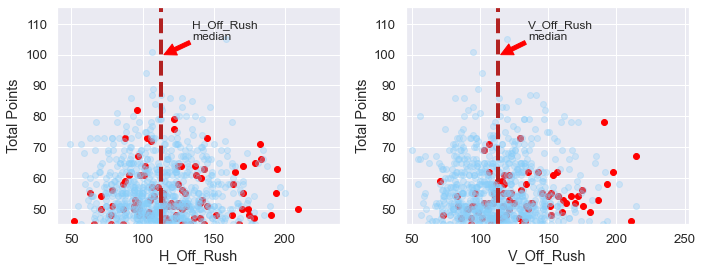

In [637]:
fig19 = plt.figure(figsize=(10,4))
#sub1 = dfgame[(dfgame['H_Off_Pass']<200) & (dfgame['Tot_Pts']>60)]
sub1 = dfgame[(dfgame['H_Off_Pass']<200) & (dfgame['Tot_Pts']>dfgame['Tot_Pts'].median())]
#nsub1 = dfgame[~((dfgame['H_Off_Pass']<200) & (dfgame['Tot_Pts']>60))]
nsub1 = dfgame[~((dfgame['H_Off_Pass']<200) & (dfgame['Tot_Pts']>dfgame['Tot_Pts'].median()))]
#sub2 = dfgame[(dfgame['V_Off_Pass']<200) & (dfgame['Tot_Pts']>60)]
sub2 = dfgame[(dfgame['V_Off_Pass']<200) & (dfgame['Tot_Pts']>dfgame['Tot_Pts'].median())]
#nsub2 = dfgame[~((dfgame['V_Off_Pass']<200) & (dfgame['Tot_Pts']>60))]
nsub2 = dfgame[~((dfgame['V_Off_Pass']<200) & (dfgame['Tot_Pts']>dfgame['Tot_Pts'].median()))]
col1 = 'H_Off_Rush'
col2 = 'V_Off_Rush'
_ = fig19.add_subplot(1,2,1)
y = sub1['Tot_Pts']
x = sub1[col1]
plt.scatter(x,y,c='red')
y = nsub1['Tot_Pts']
x = nsub1[col1]
plt.scatter(x,y,c='lightskyblue',alpha=0.3)
plt.xlabel(col1)
plt.ylabel('Total Points')
plt.xlim(min(x)*0.9,max(x)*1.1)
plt.ylim(45,max(y)*1.1)
plt.vlines(dfgame[col1].mean(),45,max(y)*1.1,color='firebrick',linestyle='dashed',linewidth=4)
plt.annotate('H_Off_Rush\nmedian',xy=(115,100),xytext=(135,105),arrowprops={'color':'red'},fontsize='small')
_ = fig19.add_subplot(1,2,2)
y = sub2['Tot_Pts']
x = sub2[col2]
plt.scatter(x,y,c='red')
y = nsub2['Tot_Pts']
x = nsub2[col2]
plt.scatter(x,y,c='lightskyblue',alpha=0.3)
plt.xlabel(col2)
plt.ylabel('Total Points')
plt.xlim(min(x)*0.9,max(x)*1.1)
plt.ylim(45,max(y)*1.1)
plt.vlines(dfgame[col2].mean(),45,max(y)*1.1,color='firebrick',linestyle='dashed',linewidth=4)
plt.annotate('V_Off_Rush\nmedian',xy=(115,100),xytext=(135,105),arrowprops={'color':'red'},fontsize='small')
fig19.tight_layout()
fig19.show()
fig19.savefig('plots/fig19.png')
print(sub1[col1].mean())
print(sub2[col2].mean())
print(dfgame[col1].mean(),dfgame[col2].mean())

In [559]:
print(sub1['H_Def_Pass'].mean())
print(sub2['V_Def_Pass'].mean())
print(dfgame['H_Def_Pass'].mean(),dfgame['V_Def_Pass'].mean())

239.2126315789472
242.44473684210516
250.97268011527342 250.0410374639769


In [509]:
print(dfgame['H_Off_Rush'].mean())
print(dfgame['H_Off_Rush'].quantile(0.77))
print(dfgame['V_Off_Rush'].quantile(0.87))

112.7850144092217
130.8
143.6


In [530]:
pts = 60
yds = 200
print(int(np.round(pts)),np.round(yds,1))
mskh = dfgame['H_Off_Pass'] < yds
mskv = dfgame['V_Off_Pass'] < yds
mskpt = dfgame['Tot_Pts'] > pts
sbh = dfgame[(mskpt)&(mskh)]
sbv = dfgame[(mskpt)&(mskv)]
print(len(sbh))
print(len(sbv))
print(sbh['H_Def_Rush'].mean(),sbh['V_Def_Rush'].mean())
print(sbv['V_Def_Rush'].mean(),sbv['H_Def_Rush'].mean())

60 200
23
13
123.5304347826087 111.31304347826088
114.60000000000001 136.36923076923077


In [532]:
dfgame['V_Def_Rush'].mean()

112.58778097982729

In [622]:
print(dfgame['H_Pts'].corr(dfgame['H_Off_Pass']))
print(dfgame['V_Pts'].corr(dfgame['V_Off_Pass']))

0.5142369503403332

In [623]:
print(dfgame['H_Pts'].corr(dfgame['Tot_Pts']))
print(dfgame['V_Pts'].corr(dfgame['Tot_Pts']))

0.1486301281728894
0.13816077875584204


In [524]:
len(sbv)

73

In [465]:
mask = (dfgame['Tot_Pts']>60)&(dfgame['H_Off_Pass']<200)
sub1 = dfgame[mask]
print(len(sub1),(sub1['H_Game'] > sub1['V_Game']).mean())
mask = (dfgame['Tot_Pts']>60)&(dfgame['V_Off_Pass']<200)
sub1 = dfgame[mask]
print(len(sub1),(sub1['H_Game'] > sub1['V_Game']).mean())

23 0.43478260869565216
13 0.38461538461538464


In [470]:
print (sub1[['H_Game','V_Game']])

              H_Game  V_Game
Code                        
201610160buf      45      16
201201010ram      27      34
201412280mia      24      37
201111060rai      24      38
201912080htx      24      38
201911100cin      13      49
201010240kan      42      20
201711260nyj      27      35
201112040min      32      35
201011280den      33      36
201010240rav      37      34
201912220mia      38      35
201011140den      49      29


In [472]:
mask = (dfgame['Tot_Pts']>60)&(dfgame['H_Off_Pass']>300)
sub2 = dfgame[mask]
print(len(sub2),(sub2['H_Game'] > sub2['V_Game']).mean())
mask = (dfgame['Tot_Pts']>60)&(dfgame['V_Off_Pass']>300)
sub2 = dfgame[mask]
print(len(sub2),(sub2['H_Game'] > sub2['V_Game']).mean())

58 0.6206896551724138
51 0.49019607843137253


In [477]:
#mask = (dfgame['H_Off_Pass'] < 200) | (dfgame['V_Off_Pass'] < 200)
mask = dfgame['Tot_Pts'] > 60
sub = dfgame[mask]
print((sub['H_Game'] > sub['V_Game']).mean())

0.5537848605577689


In [476]:
len(sub)

393

In [433]:
len(dfgame)

1735

In [141]:
print(coeffs.loc['Year',:].sort_values(ascending=False))

Year              1.000000
H_Yds_Pen         0.156124
V_Yds_Pen         0.141473
V_RZ_Pct          0.129549
Over_Under        0.120225
H_RZ_Def_Pct      0.117891
H_RZ_Pct          0.117184
V_RZ_Def_Pct      0.112909
V_Off_Pass        0.100345
H_Sacks_Def       0.096177
V_Def_Pass        0.095062
H_Def_Pass        0.094301
V_Sacks_Def       0.089029
H_Off_Pass        0.061384
V_TD              0.054029
H_Tackles_Loss    0.050943
H_TD              0.042944
grass             0.041927
V_Pts             0.034833
V_Pts_Opp         0.032509
H_Rush_Metric     0.030410
V_Game            0.025467
H_Pts_Opp         0.023373
V_Tackles_Loss    0.022677
H_Pts             0.021535
Temperature       0.013279
V_Pass_Metric     0.011949
Tot_Pts           0.011835
a_turf            0.005942
H_Game           -0.008410
H_Pass_Metric    -0.009907
V_Poss           -0.013702
Week             -0.014053
H_Poss           -0.022441
V_Rush_Metric    -0.024513
V_Plays          -0.025799
H_Off_Rush       -0.026902
f

In [103]:
print((dfgame['V_Off_Pass']>250).mean())
print((dfgame['H_Off_Pass']>250).mean())

0.48760806916426513
0.49510086455331415


In [159]:
subv = dfgame[dfgame['V_Off_Pass']>np.median(dfgame['V_Off_Pass'])]
pct=(((subv['V_Game']>subv['H_Game']).mean()/(dfgame['V_Game']>dfgame['H_Game']).mean())-1)*100
med = np.median(subv['Tot_Pts'])
print('Case: V_Off_Pass greater than median')
print('Vis winning pct increased by {:.2f}%'.format(pct))
print(f'Median total points equals {med}')

Case: V_Off_Pass greater than median
Vis winning pct increased by 11.51%
Median total points equals 47.0


In [160]:
subh = dfgame[dfgame['H_Off_Pass']>np.median(dfgame['H_Off_Pass'])]
pct = (((subh['H_Game']>subh['V_Game']).mean()/(dfgame['H_Game']>dfgame['V_Game']).mean())-1)*100
med = np.median(subh['Tot_Pts'])
print('Case: H_Off_Pass greater than median')
print('Home winning pct increased by {:.2f}%'.format(pct))
print(f'Median total points equals {med}')

Case: H_Off_Pass greater than median
Home winning pct increased by 4.47%
Median total points equals 45.0


In [176]:
vser=((subv['V_Game']>subv['H_Game']).astype('int'))/(dfgame['V_Game']>dfgame['H_Game']).mean()
hinc=(((subh['H_Game']>subh['V_Game']).astype('int'))/(dfgame['H_Game']>dfgame['V_Game']).mean()).mean()

import pingouin as pg
ttst = pg.ttest(vser,hinc,tail='one-sided')
print(ttst)

               T  dof     tail     p-val        CI95%   cohen-d  BF10    power
T-test  1.794743  865  greater  0.036522  [1.05, inf]  0.060988  0.38  0.55902


/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [199]:
ymask = dfcomp['Year'] < 2010
early=dfcomp[ymask]

In [283]:
df = dfcomp
ymask = dfcomp['Year'] >= 2010
df = df[ymask]
subv = df[df['V_Off_Pass']>np.median(df['V_Off_Pass'])]
subh = df[df['H_Off_Pass']>np.median(df['H_Off_Pass'])]
vpct = (((subv['V_Game']>subv['H_Game']).mean()/(df['V_Game']>df['H_Game']).mean())-1)*100
hpct = (((subh['H_Game']>subh['V_Game']).mean()/(df['H_Game']>df['V_Game']).mean())-1)*100
vmed = np.median(subv['Tot_Pts'])
hmed = np.median(subh['Tot_Pts'])
print('Case: V_Off_Pass greater than median')
print('Vis winning pct increased by {:.2f}%'.format(vpct))
print(f'Median total points equals {vmed}')
print('\n')
print('Case: H_Off_Pass greater than median')
print('Home winning pct increased by {:.2f}%'.format(hpct))
print(f'Median total points equals {hmed}')
print('\n')
vser = ((subv['V_Game']>subv['H_Game']).astype('int'))/(df['V_Game']>df['H_Game']).mean()
hinc=(((subh['H_Game']>subh['V_Game']).astype('int'))/(df['H_Game']>df['V_Game']).mean()).mean()
ttst = pg.ttest(vser,hinc,tail='one-sided')
print(ttst)

Case: V_Off_Pass greater than median
Vis winning pct increased by 11.51%
Median total points equals 47.0


Case: H_Off_Pass greater than median
Home winning pct increased by 4.47%
Median total points equals 45.0


               T  dof     tail     p-val        CI95%   cohen-d  BF10    power
T-test  1.794743  865  greater  0.036522  [1.05, inf]  0.060988  0.38  0.55902


/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


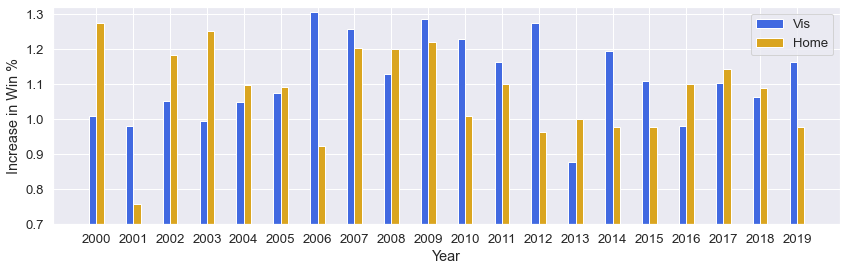

In [243]:
yr = np.arange(2000,2020)
df = dfcomp
vinc = np.empty(len(yr))
hinc = np.empty(len(yr))
for i in range(len(yr)):
    sbv = df[(df['V_Off_Pass'] > np.median(df['V_Off_Pass'])) & (df['Year'] == yr[i])]
    sbh = df[(df['H_Off_Pass'] > np.median(df['H_Off_Pass'])) & (df['Year'] == yr[i])]
    vinc[i] = ((sbv['V_Game']>sbv['H_Game'])/(df['V_Game']>df['H_Game']).mean()).mean()
    hinc[i] = ((sbh['H_Game']>sbh['V_Game'])/(df['H_Game']>df['V_Game']).mean()).mean()

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)

ind = np.arange(len(yr))  # the x locations for the groups
width = 0.2  # the width of the bars

sns.set(font_scale=1.2)
_ = plt.bar(ind - width/2, vinc, width, label='Vis',color='royalblue')
_ = plt.bar(ind + width/2, hinc, width, label='Home',color='goldenrod')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Increase in Win %')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=yr)
_ = plt.xlabel('Year')
_ = plt.legend(loc='upper right')
_ = plt.ylim(0.7,1.32)
fig.show()
fig.tight_layout()

In [ ]:
wind = dfgame[dfgame['Wind'] > 5]
wind 

In [308]:
adv = dfgame.copy(deep=False)
adv['H_Win'] = (adv['H_Game'] > adv['V_Game']).astype('int')
adv['Margin'] = adv['H_Game'] - adv['V_Game']

In [322]:
col = 'H_Win'
coeffs = adv.corr()
ind=np.flip(np.argsort(abs(coeffs.loc[col,:])))
print(coeffs.iloc[ind[4:19],coeffs.columns.get_loc(col)])

V_Pts        -0.205506
H_Pts         0.187632
V_TD         -0.185531
H_Pts_Opp    -0.165347
H_TD          0.163099
H_TO_Lost    -0.157248
H_Def_Rush   -0.142614
V_Poss       -0.118575
V_TO_Lost     0.117450
V_Off_Pass   -0.114712
V_Pts_Opp     0.104286
V_Def_Rush    0.103121
V_RZ_Pct     -0.101355
V_Off_Rush   -0.094237
H_Poss        0.091177
Name: H_Win, dtype: float64


In [362]:
train_ratio = 0.7
seed = 37
ou = dfgame.copy(deep=False)
ou['Over'] = (ou['Tot_Pts'] > ou['Over_Under']).astype('int')
X = ou.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game','H_Win','Margin','Over'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = ou['Over']

X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
X_train = sm.add_constant(X_train)
sca_train = sm.add_constant(sca_train)
scaled = sm.Logit(y_train, sca_train).fit()
sca_val = sm.add_constant(robust.transform(X_val))
ypred=scaled.predict(sca_val)
#print(f'MAE = {mean_absolute_error(y_val,ypred)}')
#print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
scaled.summary()

Optimization terminated successfully.
         Current function value: 0.668191
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Over   No. Observations:                 1215
Model:                          Logit   Df Residuals:                     1164
Method:                           MLE   Df Model:                           50
Date:                Fri, 19 Feb 2021   Pseudo R-squ.:                 0.03496
Time:                        10:39:12   Log-Likelihood:                -811.85
converged:                       True   LL-Null:                       -841.26
Covariance Type:            nonrobust   LLR p-value:                    0.1838
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0867      0.113      0.767      0.443      -0.135       0.308
H_Pts              0.2135      0.375      0.569      0.569      -0.522       0.949
H_Pts_Opp         -0.2169      0.169     -1.282      0.200      -0.549       0.115
V_Pts             -0.3256      0.379     -0.858      0.391      -1.069       0.418
V_Pts_Opp         -0.2777      0.170     -1.635      0.102      -0.611       0.055
H_Off_Pass         0.0887      0.284      0.312      0.755      -0.468       0.645
H_Pass_Metric     -0.4180      0.329     -1.272      0.203      -1.062       0.226
V_Off_Pass         0.0919      0.286      0.322      0.748      -0.468       0.652
V_Pass_Metric     -0.0874      0.325     -0.269      0.788      -0.725       0.550
H_Off_Rush        -0.3874      0.223     -1.738      0.082      -0.824       0.049
H_Rush_Metric      0.4833      0.289      1.674      0.094      -0.082       1.049
V_Off_Rush        -0.1727      0.227     -0.759      0.448      -0.618       0.273
V_Rush_Metric      0.2522      0.317      0.795      0.427      -0.370       0.874
H_Def_Pass        -0.0324      0.248     -0.130      0.896      -0.519       0.455
V_Def_Pass        -0.1277      0.257     -0.497      0.619      -0.631       0.376
H_Def_Rush         0.2110      0.224      0.942      0.346      -0.228       0.650
V_Def_Rush         0.2531      0.220      1.150      0.250      -0.178       0.684
H_TD              -0.1778      0.401     -0.443      0.657      -0.964       0.608
V_TD               0.0259      0.401      0.065      0.948      -0.761       0.813
H_TD_on_Def        0.0195      0.081      0.239      0.811      -0.140       0.179
V_TD_on_Def        0.0746      0.078      0.954      0.340      -0.079       0.228
H_FG_Pct          -0.1076      0.093     -1.162      0.245      -0.289       0.074
V_FG_Pct           0.0832      0.093      0.892      0.373      -0.100       0.266
H_RZ_Pct           0.0591      0.152      0.390      0.697      -0.238       0.356
V_RZ_Pct           0.1389      0.160      0.868      0.386      -0.175       0.453
H_RZ_Def_Pct       0.0474      0.102      0.463      0.644      -0.153       0.248
V_RZ_Def_Pct       0.2251      0.100      2.240      0.025       0.028       0.422
H_Poss            -0.0796      0.141     -0.564      0.572      -0.356       0.197
V_Poss            -0.0215      0.129     -0.167      0.867      -0.274       0.231
H_Plays            0.0958      0.139      0.691      0.489      -0.176       0.367
V_Plays            0.1926      0.125      1.545      0.122      -0.052       0.437
H_TO_Gain         -0.0821      0.111     -0.742      0.458      -0.299       0.135
V_TO_Gain         -0.0431      0.107     -0.404      0.686      -0.253       0.166
H_TO_Lost         -0.0048      0.109     -0.044      0.965      -0.219       0.209
V_TO_Lost          0.0192      0.107      0.179      0.858      -0.190       0.229
H_Yds_Pen          0.2781      0.090      3.079      0.002       0.101       0.455
V_Yd

In [361]:
print((((ypred<0.38)&(y_val==0))|((ypred>0.62)&(y_val==1))).sum())

48


In [360]:
print(((ypred<0.38)|(ypred>0.62)).sum())

82


In [351]:
ypred

array([0.46767079, 0.62492757, 0.55174479, 0.5076678 , 0.38975151,
       0.54970574, 0.48316592, 0.44527389, 0.5499205 , 0.44400266,
       0.47733931, 0.48399669, 0.48900163, 0.58088707, 0.48674417,
       0.36703537, 0.35519307, 0.35283248, 0.29308335, 0.43657419,
       0.55085823, 0.43503954, 0.3987641 , 0.60055466, 0.6748925 ,
       0.24016514, 0.42517452, 0.41649813, 0.51490283, 0.5429246 ,
       0.56360322, 0.49702379, 0.3113093 , 0.47259267, 0.37326671,
       0.48705306, 0.50888602, 0.3892585 , 0.62518641, 0.23101375,
       0.39722246, 0.55643786, 0.39327201, 0.3287633 , 0.3175794 ,
       0.39982546, 0.43457561, 0.54904217, 0.55520654, 0.51685282,
       0.42234247, 0.37621174, 0.50597576, 0.36228388, 0.31291812,
       0.56203567, 0.51630081, 0.48057743, 0.39789787, 0.53715809,
       0.34760749, 0.54495914, 0.32519606, 0.60406407, 0.61506683,
       0.49661892, 0.66135402, 0.46862098, 0.37324051, 0.39647674,
       0.44538279, 0.52662089, 0.3098345 , 0.48855161, 0.66637

In [343]:
train_ratio = 0.7
seed = 37
X = adv.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game','H_Win','Margin'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = adv['H_Win']

X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
X_train = sm.add_constant(X_train)
sca_train = sm.add_constant(sca_train)
# sca_val = robust.transform(X_val)
# sca_val = sm.add_constant(sca_val)
scaled = sm.Logit(y_train, sca_train).fit()
scaled.summary()

Optimization terminated successfully.
         Current function value: 0.592963
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  H_Win   No. Observations:                 1215
Model:                          Logit   Df Residuals:                     1164
Method:                           MLE   Df Model:                           50
Date:                Fri, 19 Feb 2021   Pseudo R-squ.:                  0.1341
Time:                        09:31:20   Log-Likelihood:                -720.45
converged:                       True   LL-Null:                       -832.00
Covariance Type:            nonrobust   LLR p-value:                 1.010e-23
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3760      0.133      2.836      0.005       0.116       0.636
H_Pts              0.8250      0.413      1.998      0.046       0.016       1.634
H_Pts_Opp         -0.3665      0.180     -2.031      0.042      -0.720      -0.013
V_Pts             -0.9937      0.381     -2.607      0.009      -1.741      -0.247
V_Pts_Opp          0.4686      0.185      2.531      0.011       0.106       0.831
H_Off_Pass        -0.0611      0.315     -0.194      0.846      -0.679       0.556
H_Pass_Metric      0.3071      0.363      0.845      0.398      -0.405       1.019
V_Off_Pass        -0.1586      0.309     -0.513      0.608      -0.765       0.448
V_Pass_Metric     -0.1835      0.336     -0.546      0.585      -0.842       0.475
H_Off_Rush         0.0196      0.234      0.084      0.933      -0.438       0.478
H_Rush_Metric     -0.1234      0.299     -0.413      0.680      -0.709       0.462
V_Off_Rush        -0.2135      0.246     -0.869      0.385      -0.695       0.268
V_Rush_Metric      0.0494      0.342      0.144      0.885      -0.620       0.719
H_Def_Pass        -0.2387      0.274     -0.873      0.383      -0.775       0.297
V_Def_Pass         0.1408      0.276      0.510      0.610      -0.400       0.682
H_Def_Rush        -0.2511      0.235     -1.068      0.286      -0.712       0.210
V_Def_Rush        -0.1478      0.238     -0.620      0.535      -0.615       0.320
H_TD              -0.0266      0.443     -0.060      0.952      -0.895       0.841
V_TD               0.4313      0.415      1.040      0.298      -0.381       1.244
H_TD_on_Def       -0.0431      0.087     -0.498      0.619      -0.213       0.127
V_TD_on_Def        0.0243      0.085      0.285      0.776      -0.143       0.191
H_FG_Pct           0.0649      0.097      0.671      0.502      -0.125       0.254
V_FG_Pct           0.0046      0.098      0.047      0.963      -0.187       0.196
H_RZ_Pct          -0.1631      0.165     -0.991      0.322      -0.486       0.160
V_RZ_Pct          -0.0053      0.166     -0.032      0.975      -0.331       0.321
H_RZ_Def_Pct       0.1908      0.112      1.700      0.089      -0.029       0.411
V_RZ_Def_Pct      -0.0529      0.108     -0.488      0.626      -0.266       0.160
H_Poss            -0.2731      0.144     -1.893      0.058      -0.556       0.010
V_Poss             0.0121      0.134      0.090      0.928      -0.250       0.274
H_Plays           -0.0920      0.150     -0.614      0.539      -0.386       0.202
V_Plays            0.0884      0.132      0.669      0.503      -0.170       0.347
H_TO_Gain         -0.1277      0.116     -1.098      0.272      -0.356       0.100
V_TO_Gain          0.1214      0.117      1.040      0.299      -0.107       0.350
H_TO_Lost         -0.2790      0.118     -2.370      0.018      -0.510      -0.048
V_TO_Lost          0.1200      0.115      1.040      0.298      -0.106       0.346
H_Yds_Pen         -0.0592      0.099     -0.599      0.549      -0.253       0.135
V_Yd

In [323]:
col = 'Margin'
coeffs = adv.corr()
ind=np.flip(np.argsort(abs(coeffs.loc[col,:])))
print(coeffs.iloc[ind[4:19],coeffs.columns.get_loc(col)])

H_Pts         0.235672
H_TD          0.214652
V_Pts        -0.205580
V_TD         -0.185244
H_Pts_Opp    -0.163291
H_TO_Lost    -0.144056
V_Def_Rush    0.127139
V_RZ_Pct     -0.119935
H_Off_Pass    0.117429
V_Pts_Opp     0.117369
H_Def_Rush   -0.117345
H_RZ_Pct      0.116568
V_TO_Lost     0.116350
V_Poss       -0.113431
V_Off_Pass   -0.108299
Name: Margin, dtype: float64


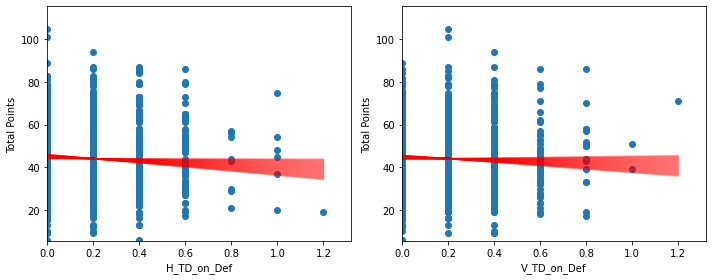

In [159]:
fig = plt.figure(figsize=(10,4))
cats = ['H_TD_on_Def','V_TD_on_Def']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(1,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
plt.tight_layout()
plt.show()

In [51]:
points = 0
hmean = dfgame[dfgame['H_Game']>points]['Tot_Pts'].mean()
hpct = len(dfgame[dfgame['H_Game']>points])/len(dfgame)*100
vmean = dfgame[dfgame['V_Game']>points]['Tot_Pts'].mean()
vpct = len(dfgame[dfgame['V_Game']>points])/len(dfgame)*100
print(f'Tot_Pts mean is {hmean} when home team scores more than {points}, {hpct:.2f}')
print(f'Tot_Pts mean is {vmean} when vis team scores more than {points}, {vpct:.2f}')

Tot_Pts mean is 45.38998835855646 when home team scores more than 0, 99.02
Tot_Pts mean is 45.38281706604325 when vis team scores more than 0, 98.62


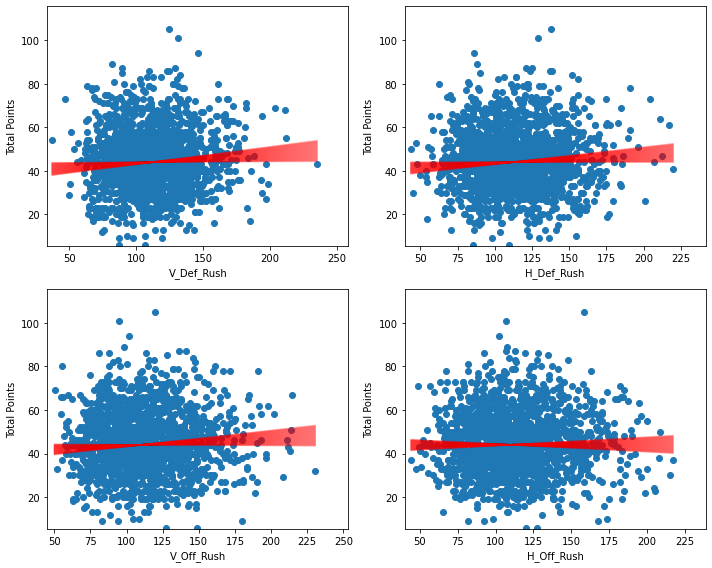

In [161]:
fig = plt.figure(figsize=(10,8))
cats = ['V_Def_Rush','H_Def_Rush','V_Off_Rush','H_Off_Rush']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(2,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
plt.tight_layout()
plt.show()

MAE = 11.038172158131122
Validation Accuracy = 0.515625


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.969
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           2.96e-14
Time:                        06:26:09   Log-Likelihood:                -4834.6
No. Observations:                1213   AIC:                             9747.
Df Residuals:                    1174   BIC:                             9946.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            473.4515    354.927      1.334      0.182    -222.911    1169.814
H_Pts              0.3573      0.137      2.614      0.009       0.089       0.625
H_Pts_Opp          0.1439      0.156      0.921      0.357      -0.163       0.451
V_Pts              0.0059      0.136      0.043      0.966      -0.260       0.272
V_Pts_Opp         -0.1899      0.151     -1.257      0.209      -0.486       0.107
H_Off_Pass         0.0075      0.015      0.498      0.618      -0.022       0.037
V_Off_Pass         0.0464      0.015      3.086      0.002       0.017       0.076
H_Off_Rush        -0.0047      0.020     -0.243      0.808      -0.043       0.034
V_Off_Rush         0.0358      0.020      1.784      0.075      -0.004       0.075
H_Def_Pass        -0.0029      0.015     -0.193      0.847      -0.033       0.027
V_Def_Pass         0.0331      0.015      2.218      0.027       0.004       0.062
H_Def_Rush         0.0311      0.020      1.538      0.124      -0.009       0.071
V_Def_Rush         0.0338      0.020      1.716      0.086      -0.005       0.072
H_TD_on_Def       -4.8157      2.480     -1.942      0.052      -9.681       0.050
V_TD_on_Def       -2.5735      2.493     -1.032      0.302      -7.465       2.318
H_FG_Pct          -2.1763      3.212     -0.678      0.498      -8.479       4.126
V_FG_Pct           3.7511      3.068      1.223      0.222      -2.268       9.771
H_RZ_Def_Pct      -2.6245      4.132     -0.635      0.525     -10.731       5.482
V_RZ_Def_Pct      15.9557      4.069      3.921      0.000       7.972      23.939
H_TO_Gain          0.6783      0.825      0.822      0.411      -0.941       2.298
V_TO_Gain          1.0000      0.826      1.210      0.226      -0.621       2.621
H_TO_Lost         -0.6300      0.854     -0.737      0.461      -2.306       1.046
V_TO_Lost          1.2012      0.820      1.465      0.143      -0.407       2.809
H_Yds_Pen          0.0323      0.031      1.034      0.301      -0.029       0.094
V_Yds_Pen          0.0342      0.031      1.091      0.276      -0.027       0.096
H_Sacks_Def        0.2261      0.623      0.363      0.717      -0.997       1.449
V_Sacks_Def        0.1043      0.626      0.167      0.868      -1.124       1.332
H_Tackles_Loss     0.2841      0.438      0.648      0.517      -0.576       1.144
V_Tackles_Loss     0.2560      0.421      0.608      0.543      -0.570       1.082
H_Kickret         -0.0972      0.076     -1.279      0.201      -0.246       0.052
V_Kickret         -0.0664      0.071     -0.937      0.349      -0.206       0.073
H_Puntret         -0.0530      0.101     -0.525      0.600      -0.251       0.145
V_Puntret         -0.1864      0.100     -1.869      0.062      -0.382       0.009
Temperature        0.0051      0.027      0.191      0.848      -0.047       0.057
Wind        

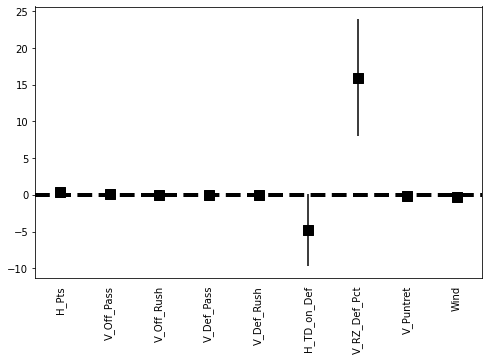

In [156]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm

dropped = ['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game','a_turf','astroplay','fieldturf',
           'sportturf','matrixturf','H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric',
           'V_Rush_Metric','H_RZ_Pct','V_RZ_Pct','H_Poss','V_Poss','H_Plays','V_Plays']
X = dfgame[dfgame['Wind']<35].drop(dropped,axis=1)
y = dfgame[dfgame['Wind']<35]['Tot_Pts']

train_ratio = 0.7
seed = 37
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
not_scaled = sm.OLS(y_train, X_train).fit()
ypred=not_scaled.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
plot_coef(not_scaled,p_thresh=0.10)
not_scaled.summary()

In [41]:
X.columns[np.nonzero(rfe.support_)]

Index(['H_TD', 'V_TD', 'H_TD_on_Def', 'V_TD_on_Def', 'H_FG_Pct', 'V_FG_Pct',
       'H_RZ_Pct', 'V_RZ_Pct', 'V_RZ_Def_Pct', 'grass'],
      dtype='object')

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
LR = linear_model.LinearRegression()
robust = RobustScaler()
sca_train = robust.fit_transform(X_train)
sca_val = robust.transform(X_val)
for num_features in range (5,26):
    rfe = RFE(estimator=LR,n_features_to_select=num_features)
    rfe.fit(sca_train,y_train)
    ypred = rfe.predict(sca_train)
    # support=pd.DataFrame(rfe.support_,index=X_train.columns)
    # print(support)
    print(f'{num_features} number of features selected')
    print(X.columns[np.nonzero(rfe.support_)])
    print(f'MAE_train = {mean_absolute_error(y_train,ypred)}')
    print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
    ypred = rfe.predict(sca_val)
    print(f'MAE = {mean_absolute_error(y_val,ypred)}')
    print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')

5 number of features selected
Index(['H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'V_RZ_Def_Pct', 'Wind'], dtype='object')
MAE_train = 10.555614109927607
Training Accuracy = 0.5417362270450752
MAE = 10.870576102933518
Validation Accuracy = 0.5019607843137255
6 number of features selected
Index(['H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'V_Pass_Metric',
       'V_RZ_Def_Pct', 'Wind'],
      dtype='object')
MAE_train = 10.566694390915478
Training Accuracy = 0.5367278797996661
MAE = 10.802051148616766
Validation Accuracy = 0.5254901960784314
7 number of features selected
Index(['H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'V_Pass_Metric',
       'H_Def_Pass', 'V_RZ_Def_Pct', 'Wind'],
      dtype='object')
MAE_train = 10.559526681844275
Training Accuracy = 0.5450751252086812
MAE = 10.794307491305453
Validation Accuracy = 0.5372549019607843
8 number of features selected
Index(['H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'V_Pass_Metric',
       'H_Def_Pass', 'H_TD', 'V_RZ_Def_Pct', 'Wind

In [643]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GroupKFold
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
LR = linear_model.LinearRegression()
robust = RobustScaler()
sca_train = robust.fit_transform(X_train)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
scoring=make_scorer(mean_absolute_error,greater_is_better=False)
rfe = RFECV(estimator=LR,min_features_to_select=5,cv=GKF.split(sca_train,y_train,groups),scoring=scoring)
rfe.fit(sca_train,y_train)
ypred = rfe.predict(sca_train)
num_features = rfe.n_features_
print(f'{num_features} number of features selected')
print(X.columns[np.nonzero(rfe.support_)])
print(f'Best MAE = {-max(rfe.grid_scores_)}')
print(rfe.grid_scores_)

22 number of features selected
Index(['H_Pts', 'H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'V_Pass_Metric',
       'H_Off_Rush', 'H_Rush_Metric', 'V_Rush_Metric', 'H_Def_Pass',
       'V_Def_Pass', 'H_Def_Rush', 'V_Def_Rush', 'V_FG_Pct', 'V_RZ_Pct',
       'V_RZ_Def_Pct', 'V_Poss', 'H_Plays', 'V_Plays', 'H_Yds_Pen',
       'V_Puntret', 'Wind', 'grass'],
      dtype='object')
Best MAE = 10.754294666874078


In [652]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Ridge
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf','Week','Year'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(alpha = 0.68, normalize=True)
robust = RobustScaler()
sca_train = robust.fit_transform(X_train)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
scoring=make_scorer(mean_absolute_error,greater_is_better=False)
rfe = RFECV(estimator=ridge,min_features_to_select=5,cv=GKF.split(sca_train,y_train,groups),scoring=scoring)
rfe.fit(sca_train,y_train)
ypred = rfe.predict(sca_train)
num_features = rfe.n_features_
print(f'{num_features} number of features selected')
print(X.columns[np.nonzero(rfe.support_)])
print(f'Best MAE = {-max(rfe.grid_scores_)}')


25 number of features selected
Index(['H_Pts', 'V_Pts', 'V_Pts_Opp', 'H_Off_Pass', 'V_Off_Pass', 'H_Def_Pass',
       'V_Def_Pass', 'H_Def_Rush', 'V_Def_Rush', 'H_TD', 'V_TD', 'V_FG_Pct',
       'V_RZ_Pct', 'V_RZ_Def_Pct', 'H_Plays', 'V_Plays', 'H_TO_Gain',
       'V_TO_Gain', 'H_Yds_Pen', 'H_Kickret', 'V_Puntret', 'Temperature',
       'Wind', 'grass', 'dome'],
      dtype='object')
Best MAE = 10.688982107854157


In [655]:
print_time()
seed = 37
n_splits = 5
X = dfgame[['H_Pts', 'V_Pts', 'V_Pts_Opp', 'H_Off_Pass', 'V_Off_Pass', 'H_Def_Pass','V_Def_Rush', 
            'H_TD', 'V_TD', 'V_FG_Pct', 'V_RZ_Pct', 'V_RZ_Def_Pct', 'H_Plays', 'V_Plays', 'H_TO_Gain',
            'V_TO_Gain', 'H_Yds_Pen', 'H_Kickret', 'V_Puntret', 'Temperature','Wind', 'grass', 'dome']]
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(alpha = 0.68, normalize=True)
robust = RobustScaler()
sca_train = robust.fit_transform(X_train)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,ridge,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

02-24-21 12:24:11
Ridge(alpha=0.68, normalize=True) n_splits = 5
MAE: 10.662±0.141
acc: 0.534±0.030


In [372]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8,max_features=8,
                                        criterion='mae')
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,RF,scale=False)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 09:42:45
RandomForestRegressor(criterion='mae', max_depth=8, max_features=8,
                      random_state=37) n_splits = 5
MAE: 10.688±0.063
acc: 0.530±0.015
V_Off_Pass                0.052543
V_Pts                     0.045974
V_Def_Pass                0.042647
V_RZ_Def_Pct              0.037533
H_Pts                     0.037109
H_Off_Rush                0.035412
V_Puntret                 0.034564
H_Off_Pass                0.034040
H_Def_Pass                0.031930
H_Puntret                 0.031561
H_RZ_Def_Pct              0.030387
V_Off_Rush                0.030282
H_Def_Rush                0.029602
H_Pts_Opp                 0.029478
Temperature               0.026922
H_Kickret                 0.026653
V_Kickret                 0.026308
V_Def_Rush                0.025960
V_FG_Pct                  0.023781
V_Tackles_Loss            0.023251
V_Yds_Pen                 0.023152
V_Pts_Opp                 0.022885
Wind                      0.022394
H_Tackles_Loss        

In [536]:
from sklearn import ensemble
from sklearn.model_selection import GroupKFold
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8
                                        criterion='mae')
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,RF,scale=False)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

02-23-21 14:46:31
RandomForestRegressor(criterion='mae', max_depth=8, random_state=37) n_splits = 5
MAE: 10.702±0.071
acc: 0.526±0.022
V_Off_Pass        0.065869
V_Def_Pass        0.055859
H_Off_Pass        0.044227
V_Pts             0.042384
V_Puntret         0.041889
H_Pts             0.041700
H_Off_Rush        0.039272
H_Puntret         0.035696
V_Off_Rush        0.034464
Temperature       0.033852
H_Def_Pass        0.032854
V_Kickret         0.031876
H_Pts_Opp         0.030739
H_Kickret         0.030417
V_RZ_Def_Pct      0.030222
V_Yds_Pen         0.028917
H_RZ_Def_Pct      0.028613
H_Yds_Pen         0.027893
Wind              0.027746
V_Def_Rush        0.026136
H_Def_Rush        0.025522
V_Pts_Opp         0.025507
H_FG_Pct          0.023271
V_Tackles_Loss    0.020998
V_FG_Pct          0.020988
H_Tackles_Loss    0.019560
V_Sacks_Def       0.017602
V_TO_Gain         0.016367
H_TO_Lost         0.015997
V_TO_Lost         0.015568
H_Sacks_Def       0.015136
Week              0.014531
H

In [541]:
print_time()
seed = 37
train_ratio = 0.70
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
RF=ensemble.RandomForestRegressor(random_state=seed,max_depth=8,max_features=22,criterion='mae')
RF.fit(X_train, y_train)
ypred = RF.predict(X_val)
mae = mean_absolute_error(y_val, ypred) 
acc = ou_accuracy(y_val, ypred)
print('MAE: {0:.3f}'.format(mae))
print('acc: {0:.3f}'.format(acc))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

02-23-21 14:57:12
MAE: 10.713
acc: 0.533
V_Off_Pass        0.081358
V_Def_Pass        0.043480
H_Off_Rush        0.040245
H_Off_Pass        0.039901
H_Pts             0.038817
V_Puntret         0.038481
H_Puntret         0.038022
Temperature       0.036593
H_Def_Pass        0.036527
V_RZ_Def_Pct      0.036097
H_Pts_Opp         0.033821
Wind              0.033416
V_Yds_Pen         0.031261
V_Def_Rush        0.030584
V_Off_Rush        0.028892
V_Pts             0.028601
H_Kickret         0.028213
V_Kickret         0.028088
V_Pts_Opp         0.027306
H_Def_Rush        0.027025
H_Yds_Pen         0.025487
H_Tackles_Loss    0.022080
H_RZ_Def_Pct      0.020941
V_TO_Gain         0.019920
H_FG_Pct          0.019551
V_Tackles_Loss    0.019015
H_Sacks_Def       0.018412
V_Sacks_Def       0.018164
V_FG_Pct          0.017692
H_TO_Lost         0.017658
V_TO_Lost         0.015404
Week              0.014587
H_TO_Gain         0.014037
Year              0.009774
V_TD_on_Def       0.008682
H_TD_on_Def   

In [376]:
print_time()
seed = 37
train_ratio = 0.70
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8, max_features=8,
                                        criterion='mae')
RF.fit(X_train, y_train)
ypred = RF.predict(X_val)
mae = mean_absolute_error(y_val, ypred) 
acc = ou_accuracy(y_val, ypred)
print('MAE: {0:.3f}'.format(mae))
print('acc: {0:.3f}'.format(acc))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 10:02:10
MAE: 10.803
acc: 0.518
V_Off_Pass                0.061478
V_Def_Pass                0.039852
H_Off_Pass                0.039629
V_Puntret                 0.037195
H_Pts                     0.037179
V_RZ_Def_Pct              0.036089
H_Pts_Opp                 0.033668
V_Pts_Opp                 0.033090
V_Pts                     0.032966
H_Def_Pass                0.032807
Wind                      0.031999
H_Puntret                 0.030565
H_Off_Rush                0.029399
Temperature               0.028285
H_Def_Rush                0.028053
V_Kickret                 0.027586
V_Off_Rush                0.027398
V_Def_Rush                0.026224
V_Yds_Pen                 0.024733
H_RZ_Def_Pct              0.023829
H_Kickret                 0.023662
H_Yds_Pen                 0.022941
Week                      0.021434
V_FG_Pct                  0.019506
H_Sacks_Def               0.019315
V_Tackles_Loss            0.018633
H_Tackles_Loss            0.016869
H_FG_Pct      

In [291]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
lasso = Lasso(alpha = 0.009, normalize=True)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,lasso,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 06:41:28
Lasso(alpha=0.009, normalize=True) n_splits = 5
MAE: 10.715±0.197
acc: 0.523±0.030


In [262]:
print_time()
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(alpha = 0.68, normalize=True)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,ridge,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 05:39:29
Ridge(alpha=0.68, normalize=True) n_splits = 5
MAE: 10.693±0.147
acc: 0.527±0.022


In [ ]:
# Random Forest
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import graphviz
train_ratio = 0.85
param_grid = [{'n_estimators' : [200, 400, 800, 1000], 'max_depth' : [3, 6, 8, 10], 
              'max_features' : [4, 8, 16, 32, 'auto']}]
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=37)
RF = ensemble.RandomForestRegressor(random_state=77,criterion='mae')
grid_search = GridSearchCV(RF, param_grid, cv=5, 
                           scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False)},refit='mae')
grid_search.fit(X_train, y_train)

In [683]:
import graphviz
from sklearn.tree import export_graphviz
for i in range(10):
    ind = i*80
    dot_data = export_graphviz(grid_search.best_estimator_.estimators_[i], 
                               out_file=f'plots/RF_Trees/tree{i+1}.dot',
                               filled=True, rounded=True, feature_names=X.columns)

In [281]:
print_time()
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
lasso = Lasso(normalize=True)
#alphas=np.logspace(-4, 0, 17)
alphas=np.logspace(-2.5, -2, 10)
param_grid = [{'alpha' : alphas}]
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
print(lasso,f'n_splits = {GKF.get_n_splits()}')
GS = GridSearchCV(lasso, param_grid, cv=GKF.split(X_train,y_train,groups), scoring=scoring, refit='mae')
GS.fit(X_train, y_train)
GS.cv_results_

12-23-20 06:34:12
Lasso(normalize=True) n_splits = 5


{'mean_fit_time': array([0.01234055, 0.01287851, 0.01312771, 0.00820441, 0.00967746,
        0.0136869 , 0.01172776, 0.01011806, 0.00851989, 0.01162357]),
 'std_fit_time': array([0.00231181, 0.00128996, 0.00413259, 0.00114669, 0.00324002,
        0.00180229, 0.00277348, 0.00109844, 0.00126114, 0.00274582]),
 'mean_score_time': array([0.01749578, 0.0190661 , 0.0217063 , 0.01221418, 0.01590095,
        0.0185637 , 0.01650739, 0.01368437, 0.01187415, 0.01777945]),
 'std_score_time': array([0.00134866, 0.00289884, 0.01135463, 0.00028763, 0.00312797,
        0.00139106, 0.00310656, 0.00188267, 0.00023649, 0.00438768]),
 'param_alpha': masked_array(data=[0.0031622776601683794, 0.003593813663804626,
                    0.004084238652674522, 0.004641588833612777,
                    0.00527499706370262, 0.005994842503189409,
                    0.006812920690579615, 0.007742636826811269,
                    0.008799225435691074, 0.01],
              mask=[False, False, False, False, False, Fal

In [388]:
print_time()
from sklearn.linear_model import Lasso
train_ratio = 0.70
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','grass','sportturf','matrixturf','dome','fieldturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, val=True,seed=seed)
sca_train = robust.fit_transform(X_train)
sca_val = robust.transform(X_val)
#lasso = Lasso(alpha = 0.007, normalize=True)
lasso = Lasso(alpha = 0.011, normalize=True)
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
lasso.fit(sca_train,y_train)
ypred=lasso.predict(sca_val)
mae=mean_absolute_error(y_val,ypred)
acc=ou_accuracy(y_val,ypred)
sorted_coef = get_coef(lasso.coef_,X_train.columns)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
print(sorted_coef)
plot_coef()

12-23-20 10:14:08
MAE = 10.817601401649306
Validation Accuracy = 0.5215686274509804
                LR Coefficient
Wind                 -2.346999
V_Off_Pass            2.100770
H_Pts                 1.734814
V_RZ_Def_Pct          1.590835
H_Off_Pass            0.930776
V_Def_Pass            0.917549
V_Puntret            -0.567506
H_Def_Rush            0.531299
V_Pts                 0.428116
V_Off_Rush            0.257821
Week                 -0.206921
V_FG_Pct              0.094634
H_Sacks_Def           0.046750
H_Def_Pass            0.029045
H_Tackles_Loss        0.008790
V_Pts_Opp             0.000000
H_Off_Rush            0.000000
H_Pts_Opp             0.000000
Year                 -0.000000
V_Def_Rush            0.000000
H_FG_Pct             -0.000000
H_Yds_Pen             0.000000
V_Yds_Pen             0.000000
V_Sacks_Def           0.000000
V_Tackles_Loss        0.000000
H_Kickret            -0.000000
V_Kickret             0.000000
H_Puntret             0.000000
Temperature      

In [277]:
print_time()
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(normalize=True)
#alphas=np.logspace(-4, 0, 17)
alphas=np.logspace(-0.5, 0, 10)
param_grid = [{'alpha' : alphas}]
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
print(ridge,f'n_splits = {GKF.get_n_splits()}')
GS = GridSearchCV(ridge, param_grid, cv=GKF.split(X_train,y_train,groups), scoring=scoring, refit='mae')
GS.fit(X_train, y_train)
GS.cv_results_

12-23-20 06:27:40
Ridge(normalize=True) n_splits = 5


{'mean_fit_time': array([0.00662355, 0.00620189, 0.00659041, 0.01019902, 0.00662813,
        0.00459962, 0.00493422, 0.00523987, 0.00508809, 0.00470967]),
 'std_fit_time': array([1.06873087e-03, 4.70826378e-04, 7.32216356e-04, 4.75401948e-03,
        2.31460558e-03, 8.30806341e-05, 5.55422771e-04, 7.04808850e-04,
        4.76338197e-04, 1.33575477e-04]),
 'mean_score_time': array([0.01678848, 0.01608653, 0.01694975, 0.02073178, 0.01406131,
        0.01187768, 0.01256819, 0.0118567 , 0.01250119, 0.01171784]),
 'std_score_time': array([0.00140863, 0.00159323, 0.00050524, 0.00208965, 0.00211319,
        0.00056319, 0.00184516, 0.00058217, 0.00059206, 0.00045904]),
 'param_alpha': masked_array(data=[0.31622776601683794, 0.35938136638046275,
                    0.4084238652674521, 0.46415888336127786,
                    0.5274997063702618, 0.599484250318941,
                    0.6812920690579612, 0.774263682681127,
                    0.8799225435691069, 1.0],
              mask=[False, F

In [14]:
train_ratio = 0.85
mae = np.empty(7)
acc = np.empty(7)
ou = np.empty(7)
acc_ext = np.empty(7)
for n in range(7):
    path = 'data/df_working'+str(n+1)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = dfgame['Tot_Pts']
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX = XX.drop(turf,axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    m, a = regress(LR,XX_train,XX_test,yy_train,yy_test,
                   print_metrics=False,print_coef=False,return_metrics=True)
    ou[n] = mean_absolute_error(yy_test,dfgame.loc[XX_test.index,'Over/Under'])
    mae[n] = m
    acc[n] = a
print(mae)
print(acc)
print(ou-mae)

[11.34933801 11.16744056 10.48705836 10.59635947 11.09379895 10.69871393
 10.22553897]
[0.45892351 0.53012048 0.50645161 0.51590106 0.54509804 0.55339806
 0.51442308]
[-0.83544912 -0.44422627 -0.28513529 -0.24095878 -0.50567634 -0.25767619
 -0.40714275]
